In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, concatenate, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D
import matplotlib.pyplot as plt


In [2]:
df='CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone'

Data Visualisation

In [3]:
img_height = 256
img_width = 256

In [4]:
train = tf.keras.utils.image_dataset_from_directory(df, image_size=(img_height, img_width),validation_split=0.1,subset='training', seed=123)
val = tf.keras.utils.image_dataset_from_directory(df, image_size=(img_height, img_width),validation_split=0.2,subset='validation', seed=123)

Found 12446 files belonging to 4 classes.
Using 11202 files for training.
Found 12446 files belonging to 4 classes.
Using 2489 files for validation.


In [5]:
class_name = {index: name for index, name in enumerate(train.class_names)}
class_name

{0: 'Cyst', 1: 'Normal', 2: 'Stone', 3: 'Tumor'}

In [6]:
for data in train:
  image_batch, labels_batch = data
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 256, 256, 3)
(32,)


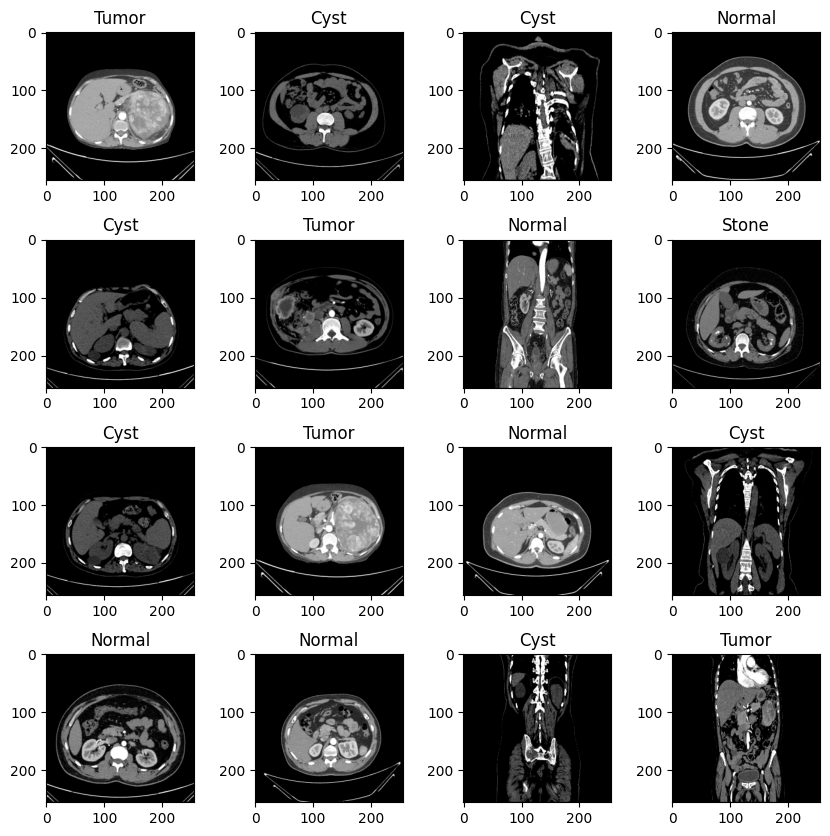

In [9]:
data_iterator = train.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(4):
    for j in range(4):
        index = i * 4 + j  
        ax[i, j].imshow(batch[0][index].astype(int))
        ax[i, j].set_title(class_name[batch[1][index]])
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()

Data Preporcessing

In [ ]:
train=train.map(lambda x,y:(x/255,y))
val=val.map(lambda x,y:(x/255,y))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

In [11]:
from tensorflow.image import resize

train = train.map(lambda x, y: (resize(x, (150, 150)), y))
val = val.map(lambda x, y: (resize(x, (150, 150)), y))


CNN Model

In [17]:
Cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)), 
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(4, activation=tf.nn.softmax)
])

In [18]:
Cnn_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [30]:
from joblib import dump

In [32]:
Cnn_model_path=r'G:\412-project\Project\savedModels\Cnn_model.joblib'
dump(Cnn_model,Cnn_model_path)

['G:\\412-project\\Project\\savedModels\\Cnn_model.joblib']

In [19]:
epochs=15
history = Cnn_model.fit(
  train,
  validation_data=val,
  epochs=epochs
)

Epoch 1/15


351/351 [==============================] - 121s 342ms/step - loss: 5.7942 - accuracy: 0.9365 - val_loss: 0.0020 - val_accuracy: 0.9992
Epoch 2/15
351/351 [==============================] - 121s 344ms/step - loss: 0.0026 - accuracy: 0.9996 - val_loss: 1.3625e-04 - val_accuracy: 1.0000
Epoch 3/15
351/351 [==============================] - 122s 346ms/step - loss: 4.2849e-05 - accuracy: 1.0000 - val_loss: 5.8105e-05 - val_accuracy: 1.0000
Epoch 4/15
351/351 [==============================] - 124s 352ms/step - loss: 1.3103e-05 - accuracy: 1.0000 - val_loss: 4.6083e-05 - val_accuracy: 1.0000
Epoch 5/15
351/351 [==============================] - 124s 353ms/step - loss: 5.6595e-06 - accuracy: 1.0000 - val_loss: 3.7363e-05 - val_accuracy: 1.0000
Epoch 6/15
351/351 [==============================] - 125s 354ms/step - loss: 3.0520e-06 - accuracy: 1.0000 - val_loss: 3.1924e-05 - val_accuracy: 1.0000
Epoch 7/15
351/351 [==============================] - 125s 356ms/step - loss: 1.9834e-06 - accuracy

In [21]:
def InceptionModule(x, filters):
    
    conv1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)
    conv3x3_reduce = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv3x3_reduce)
    conv5x5_reduce = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv5x5_reduce)
    maxpool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    maxpool_conv = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(maxpool)
    inception = concatenate([conv1x1, conv3x3, conv5x5, maxpool_conv], axis=-1)

    return inception


In [22]:
input_layer = Input(shape=(150, 150, 3))
x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = Conv2D(64, (1, 1), activation='relu')(x)
x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

x = InceptionModule(x, [64, 128, 128, 32, 32, 32])
x = InceptionModule(x, [128, 192, 96, 64, 64, 64])
x = MaxPooling2D((3, 3), strides=(2, 2))(x)

In [24]:
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
output_layer = Dense(4, activation='softmax')(x)

In [25]:
GoogLeNetmodel = Model(inputs=input_layer, outputs=output_layer)

In [28]:
GoogLeNetmodel.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [29]:
GoogLeNetmodel.fit(train, validation_data=val, epochs=15)

Epoch 1/15


351/351 [==============================] - 361s 1s/step - loss: 3.3986 - accuracy: 0.8083 - val_loss: 0.0707 - val_accuracy: 0.9691
Epoch 2/15
351/351 [==============================] - 374s 1s/step - loss: 0.0421 - accuracy: 0.9863 - val_loss: 0.0151 - val_accuracy: 0.9948
Epoch 3/15
351/351 [==============================] - 376s 1s/step - loss: 0.0486 - accuracy: 0.9834 - val_loss: 0.0184 - val_accuracy: 0.9956
Epoch 4/15
351/351 [==============================] - 378s 1s/step - loss: 0.0368 - accuracy: 0.9900 - val_loss: 0.0116 - val_accuracy: 0.9948
Epoch 5/15
351/351 [==============================] - 376s 1s/step - loss: 0.0321 - accuracy: 0.9891 - val_loss: 0.0023 - val_accuracy: 0.9988
Epoch 6/15
351/351 [==============================] - 377s 1s/step - loss: 0.0324 - accuracy: 0.9902 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 7/15
351/351 [==============================] - 379s 1s/step - loss: 3.4382e-04 - accuracy: 1.0000 - val_loss: 1.0680e-04 - val_accuracy: 1.0000
Ep